In [1]:
import requests
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from dotenv import load_dotenv
from pathlib import Path
from matplotlib.ticker import MultipleLocator

In [2]:
load_dotenv()
DATE_BEGIN = os.getenv('DATE_BEGIN')
DATE_END = os.getenv('DATE_END')
API_URL = os.getenv('API_URL')

In [3]:
visit_json = requests.get(f"{API_URL}/visits?begin={DATE_BEGIN}&end={DATE_END}")
data_vis=visit_json.json()
df_visits=pd.DataFrame(data_vis)
print(df_visits)

                             datetime platform  \
0       Wed, 01 Mar 2023 10:36:22 GMT      web   
1       Wed, 01 Mar 2023 06:25:00 GMT      web   
2       Wed, 01 Mar 2023 10:26:13 GMT      web   
3       Wed, 01 Mar 2023 12:33:06 GMT      web   
4       Wed, 01 Mar 2023 01:38:35 GMT      web   
...                               ...      ...   
263454  Tue, 29 Aug 2023 10:43:29 GMT      web   
263455  Tue, 29 Aug 2023 19:29:16 GMT      web   
263456  Tue, 29 Aug 2023 12:51:11 GMT      web   
263457  Tue, 29 Aug 2023 21:45:08 GMT      web   
263458  Wed, 30 Aug 2023 19:19:04 GMT      web   

                                               user_agent  \
0       Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...   
1       Mozilla/5.0 (Windows NT 10.0; WOW64; Trident/7...   
2       Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_2...   
3       Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7...   
4       Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...   
...                              

In [4]:
registration_json = requests.get(f"{API_URL}/registrations?begin={DATE_BEGIN}&end={DATE_END}")
data_reg=registration_json.json()
df_registrations=pd.DataFrame(data_reg)
print(df_registrations)

                            datetime                       email platform  \
0      Wed, 01 Mar 2023 07:40:13 GMT           ebyrd@example.org      web   
1      Wed, 01 Mar 2023 13:14:00 GMT    knightgerald@example.org      web   
2      Wed, 01 Mar 2023 03:05:50 GMT  cherylthompson@example.com      web   
3      Wed, 01 Mar 2023 00:04:47 GMT       halldavid@example.org      web   
4      Wed, 01 Mar 2023 18:31:52 GMT        denise86@example.net      web   
...                              ...                         ...      ...   
21831  Thu, 31 Aug 2023 07:32:08 GMT         ikelley@example.net      ios   
21832  Thu, 31 Aug 2023 23:25:50 GMT     brittanycox@example.net      ios   
21833  Thu, 31 Aug 2023 19:29:18 GMT           aryan@example.net      ios   
21834  Thu, 31 Aug 2023 19:38:54 GMT       emartinez@example.net      ios   
21835  Thu, 31 Aug 2023 08:36:05 GMT      terriperry@example.net      ios   

      registration_type                               user_id  
0          

In [5]:
df_visits = df_visits[~df_visits['user_agent'].str.contains('bot')]
df_visits['date_group'] = pd.to_datetime(df_visits['datetime']).dt.date
df_visits = df_visits.sort_values(by=['visit_id', 'date_group']).drop_duplicates(subset=['visit_id'], keep='last')
df_visits_grouped = df_visits.groupby(['date_group', 'platform']).size().reset_index(name='visits')
df_visits_grouped

,date_group,platform,visits
0,2023-03-01,android,75
1,2023-03-01,ios,22
2,2023-03-01,web,279
3,2023-03-02,android,67
4,2023-03-02,ios,31
...,...,...,...
547,2023-08-30,ios,66
548,2023-08-30,web,1227
549,2023-08-31,android,57
550,2023-08-31,ios,50


In [6]:
df_registrations['date_group'] = pd.to_datetime(df_registrations['datetime']).dt.date
df_registrations_grouped = df_registrations.groupby(['date_group', 'platform']).size().reset_index(name='registrations')
df_registrations_grouped

,date_group,platform,registrations
0,2023-03-01,android,61
1,2023-03-01,ios,18
2,2023-03-01,web,8
3,2023-03-02,android,59
4,2023-03-02,ios,24
...,...,...,...
547,2023-08-30,ios,40
548,2023-08-30,web,34
549,2023-08-31,android,42
550,2023-08-31,ios,36


In [7]:
df_merged = pd.merge(df_visits_grouped, df_registrations_grouped, on=['date_group', 'platform'], how='left')
df_merged['conversion'] = df_merged['registrations'] / df_merged['visits'] * 100
df_merged

,date_group,platform,visits,registrations,conversion
0,2023-03-01,android,75,61,81.333333
1,2023-03-01,ios,22,18,81.818182
2,2023-03-01,web,279,8,2.867384
3,2023-03-02,android,67,59,88.059701
4,2023-03-02,ios,31,24,77.419355
...,...,...,...,...,...
547,2023-08-30,ios,66,40,60.606061
548,2023-08-30,web,1227,34,2.770986
549,2023-08-31,android,57,42,73.684211
550,2023-08-31,ios,50,36,72.000000


In [8]:
df_merged.to_json('./conversion.json')

In [9]:
ads_date = pd.read_csv('ads.csv')
ads_date['date_group'] = pd.to_datetime(ads_date['date']).dt.date
ads_grouped = ads_date.groupby(['date_group', 'utm_campaign']).agg({'cost':'sum'}).reset_index()
ads = df_merged.merge(ads_grouped, left_on = 'date_group', right_on = 'date_group', how = 'left') 
ads = ads[['date_group', 'visits', 'registrations', 'cost', 'utm_campaign']]
ads['cost'] = ads['cost'].fillna(0)
ads['utm_campaign'] = ads['utm_campaign'].fillna('none')
ads

,date_group,visits,registrations,cost,utm_campaign
0,2023-03-01,75,61,212.0,advanced_algorithms_series
1,2023-03-01,22,18,212.0,advanced_algorithms_series
2,2023-03-01,279,8,212.0,advanced_algorithms_series
3,2023-03-02,67,59,252.0,advanced_algorithms_series
4,2023-03-02,31,24,252.0,advanced_algorithms_series
...,...,...,...,...,...
547,2023-08-30,66,40,109.0,intro_to_python_course
548,2023-08-30,1227,34,109.0,intro_to_python_course
549,2023-08-31,57,42,215.0,intro_to_python_course
550,2023-08-31,50,36,215.0,intro_to_python_course


In [10]:
ads.to_json('./ads.json')

In [11]:
new_folder_path = 'charts'
os.makedirs(new_folder_path, exist_ok=True)

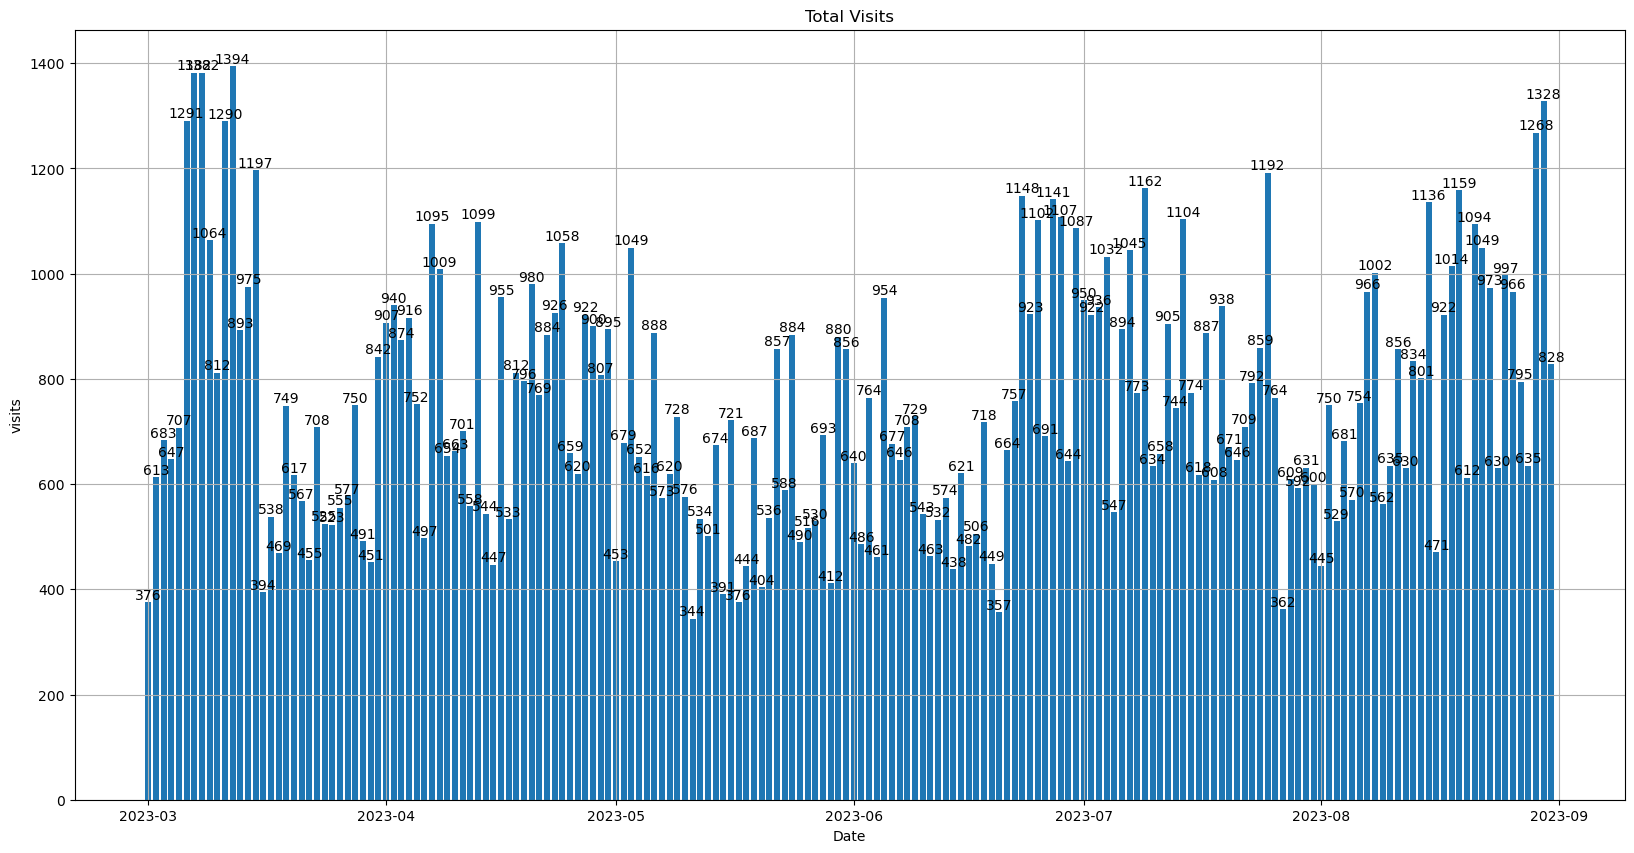

In [12]:
total_visits = ads.groupby(['date_group']).agg({'visits':'sum'}).reset_index()
fig, ax = plt.subplots(figsize=(20, 10))
plt.bar(total_visits['date_group'], total_visits['visits'])
ax.bar_label(ax.containers[0], fontsize=10)
plt.xlabel('Date')
plt.ylabel('visits')
plt.title('Total Visits')
plt.grid(True)
plt.savefig("charts/Total_Visits.png")    

C:\Users\dmitr\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


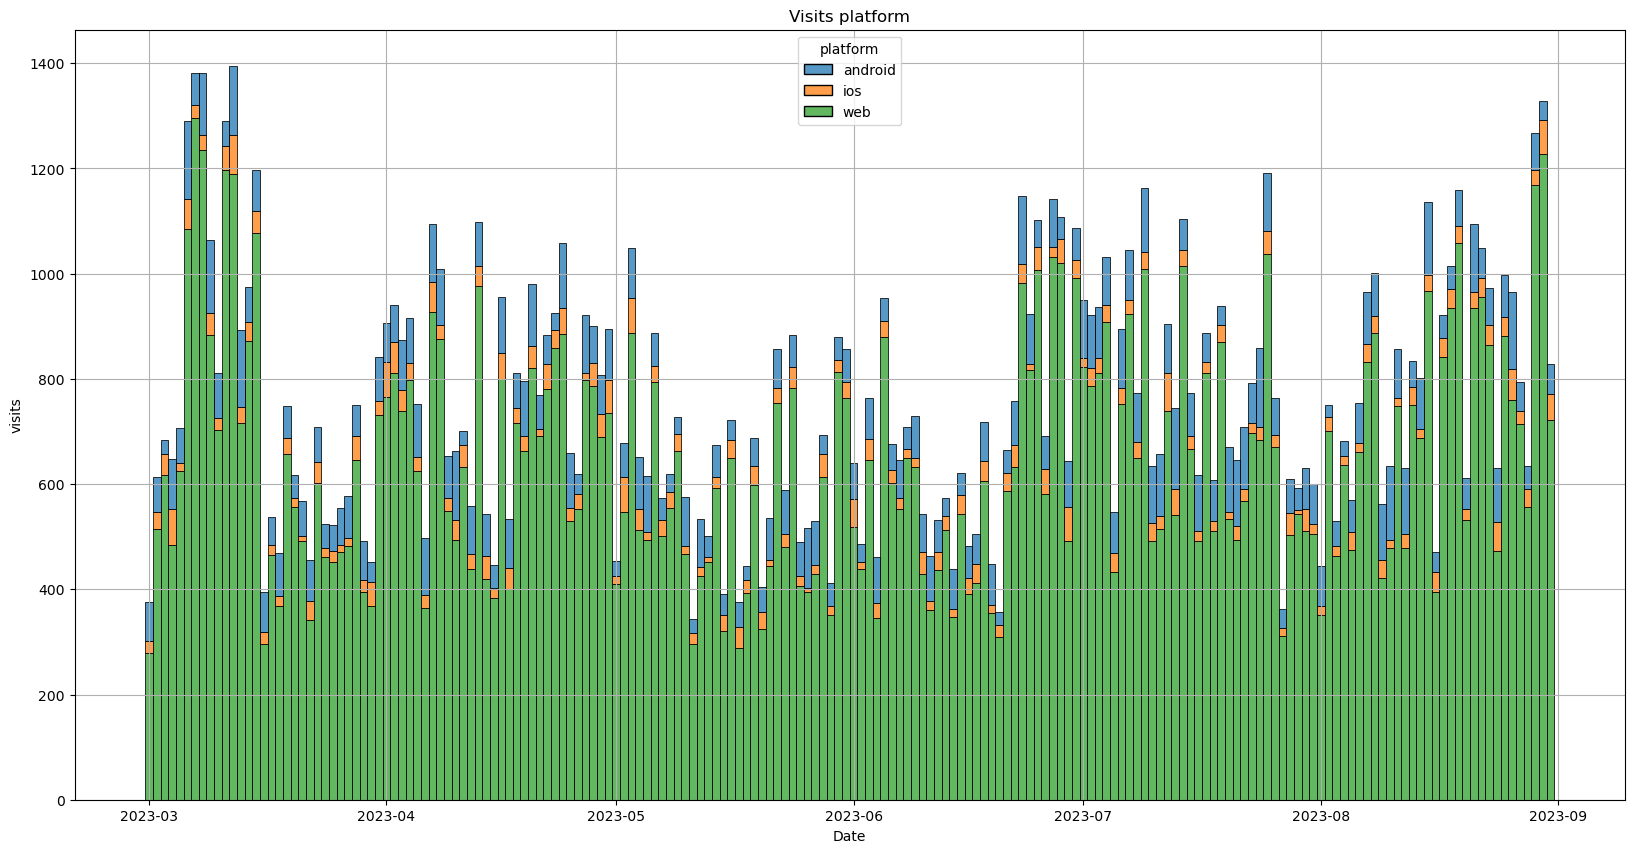

In [15]:
fig, ax = plt.subplots(figsize=(20, 10))
sns.histplot(x='date_group', weights='visits', hue = 'platform', data=df_merged, multiple='stack')
plt.xlabel('Date')
plt.ylabel('visits')
plt.title('Visits platform')
plt.grid(True)
plt.savefig('charts/Visits_Platform.png')

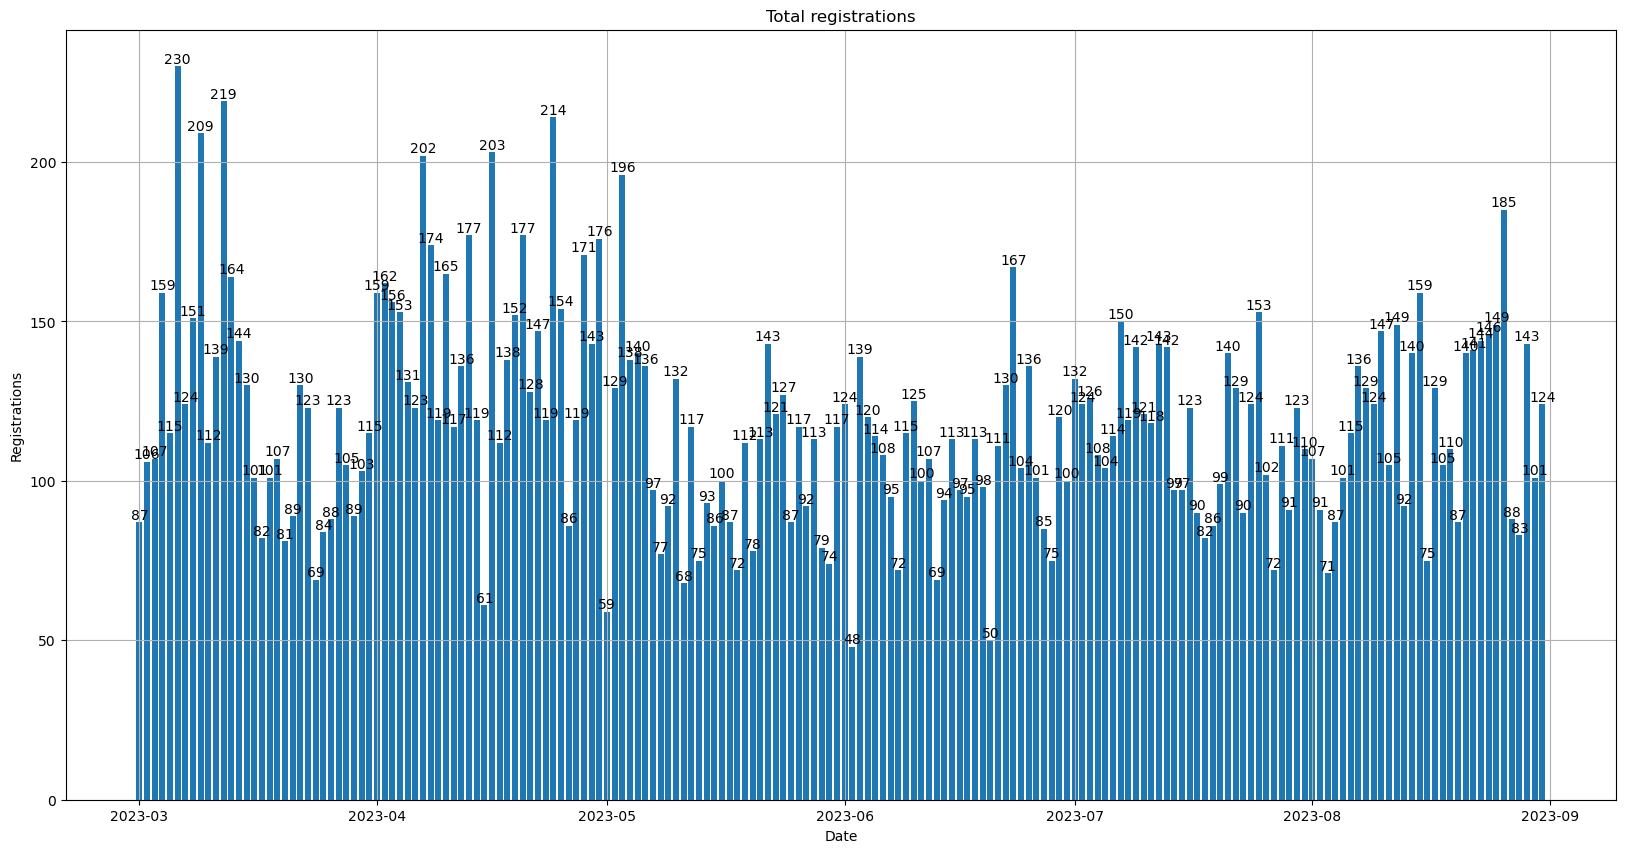

In [16]:
total_registrations = ads.groupby(['date_group']).agg({'registrations':'sum'}).reset_index()

fig, ax = plt.subplots(figsize=(20, 10))
plt.bar(total_registrations['date_group'], total_registrations['registrations'])
ax.bar_label(ax.containers[0], fontsize=10)
plt.xlabel('Date')
plt.ylabel('Registrations')
plt.title('Total registrations')
plt.grid(True)
plt.savefig('charts/Total_Registrations.png')

C:\Users\dmitr\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


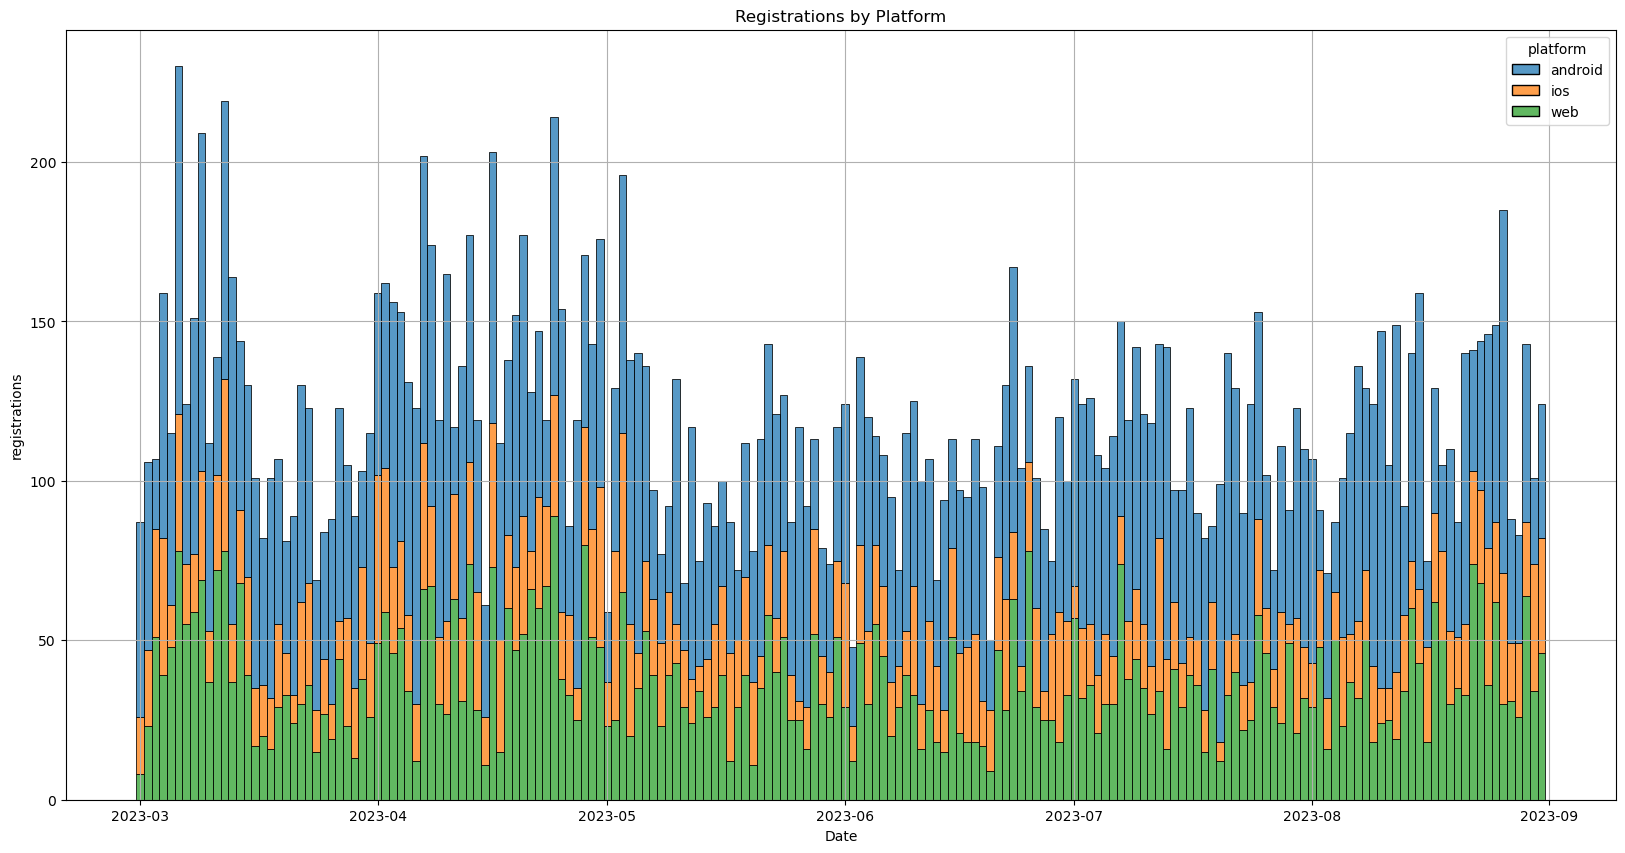

In [17]:
fig, ax = plt.subplots(figsize=(20, 10))
sns.histplot(x='date_group', weights='registrations', hue = 'platform', data=df_merged, multiple='stack')
plt.xlabel('Date')
plt.ylabel('registrations')
plt.title('Registrations by Platform')
plt.grid(True)
plt.savefig('charts/Registrations_by_Platform.png')

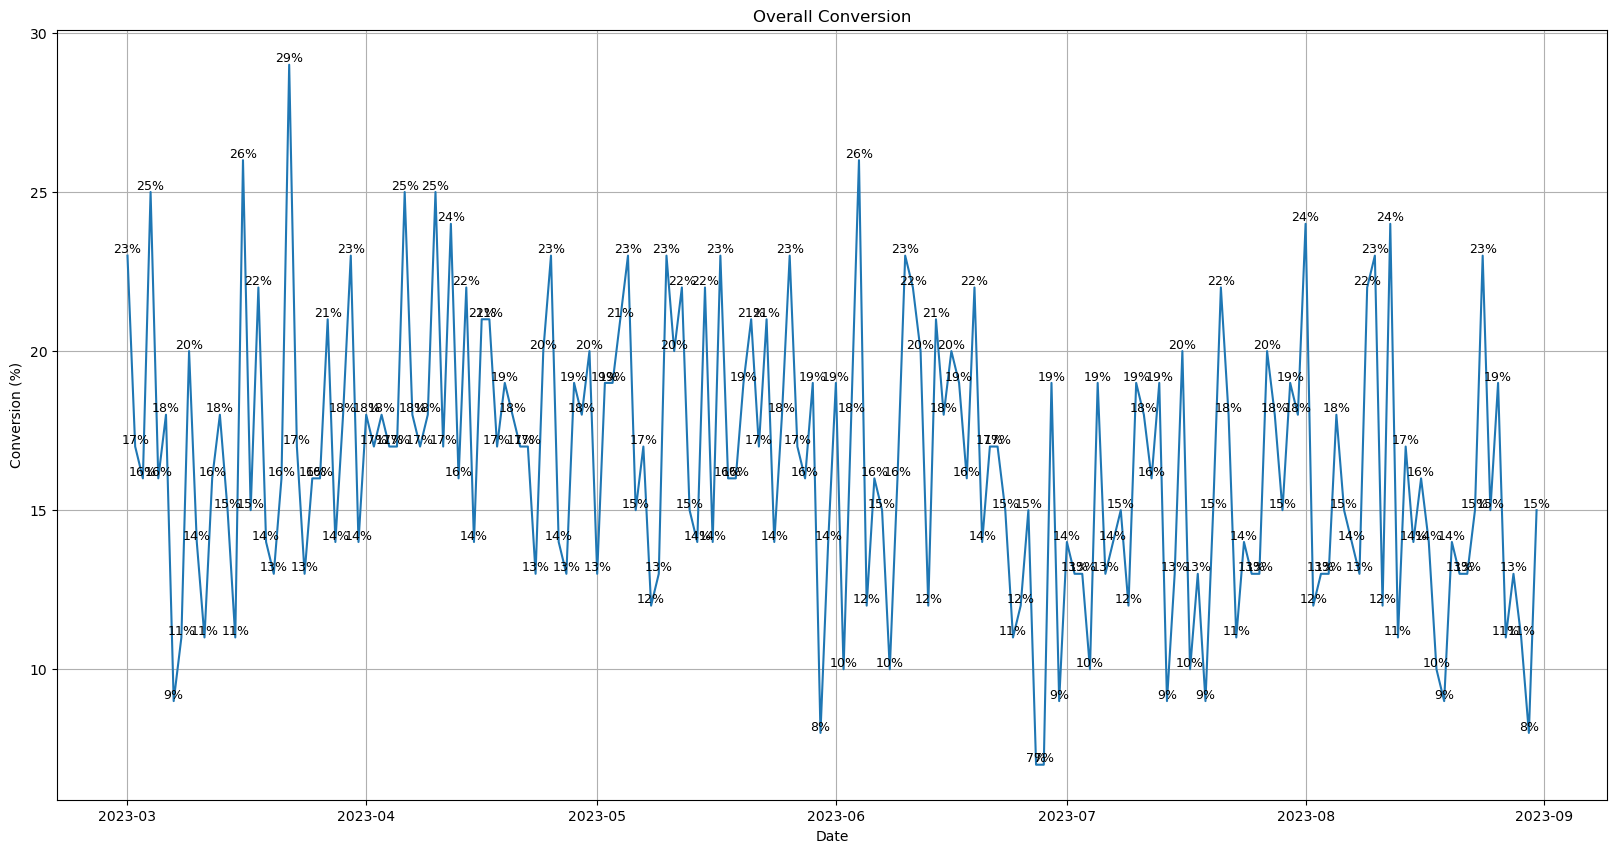

In [18]:
visits_per_day = df_merged.groupby(['date_group']).agg({'visits':'sum'})
registrations_per_day = df_merged.groupby(['date_group']).agg({'registrations':'sum'})
total_conversion = round(registrations_per_day['registrations']/visits_per_day['visits']*100, 0).reset_index()
total_conversion = total_conversion.set_axis(['date_group', 'conversion'], axis=1, copy = False)

fig, ax = plt.subplots(figsize=(20, 10))
ax.plot(total_conversion['date_group'], total_conversion['conversion'])

ax.grid(True)
ax.set_xlabel('Date')
ax.set_ylabel('Conversion (%)')
plt.title('Overall Conversion')
for x, y in zip(total_conversion['date_group'], total_conversion['conversion']):
    ax.text(x, y, f'{y:.0f}%', ha='center', va='bottom', fontsize=9)

# Save the plot to a file
plt.savefig('charts/Overall Conversion.png')

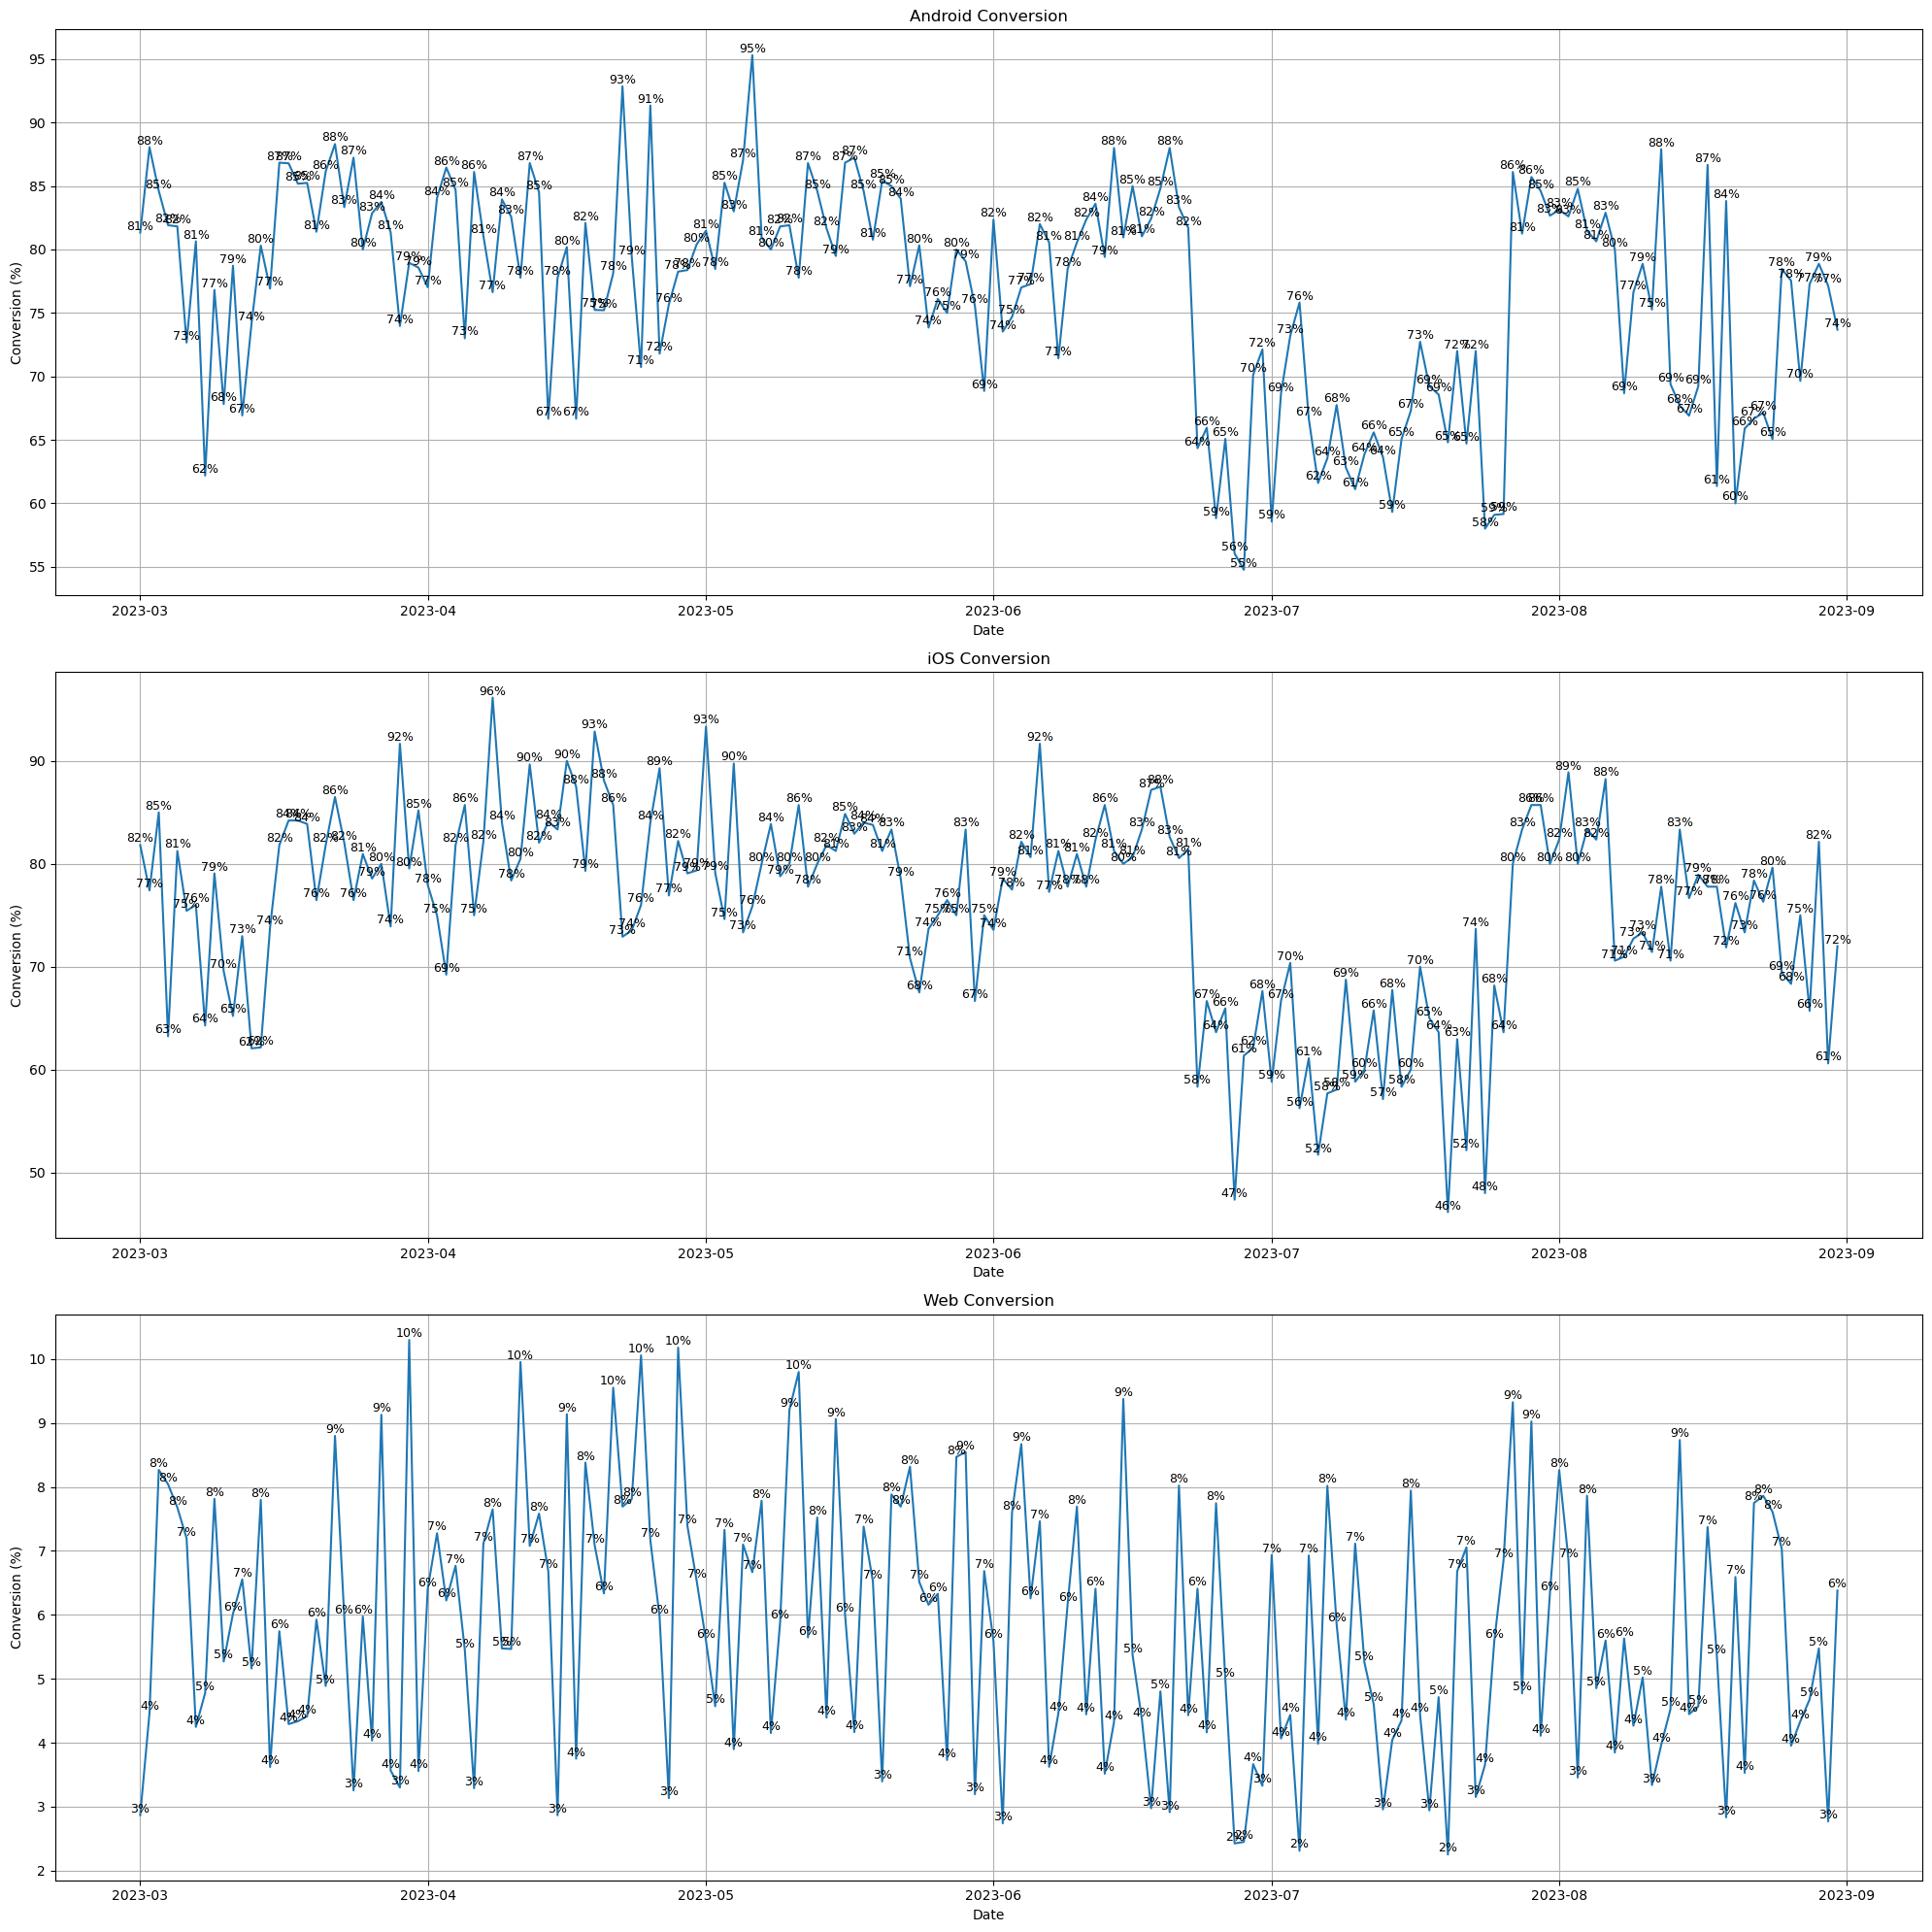

In [19]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(20, 20))

android = df_merged[df_merged['platform'] == 'android']
ax1.plot(android['date_group'], android['conversion'])
ax1.set_xlabel('Date')
ax1.set_ylabel('Conversion (%)')
ax1.set_title('Android Conversion')
ax1.grid(True)

for x, y in zip(android['date_group'], android['conversion']):
    ax1.text(x, y, f'{y:.0f}%', ha='center', va='bottom', fontsize=9)

ios = df_merged[df_merged['platform'] == 'ios']
ax2.plot(ios['date_group'], ios['conversion'])
ax2.set_xlabel('Date')
ax2.set_ylabel('Conversion (%)')
ax2.set_title('iOS Conversion')
ax2.grid(True)

for x, y in zip(ios['date_group'], ios['conversion']):
    ax2.text(x, y, f'{y:.0f}%', ha='center', va='bottom', fontsize=9)

web = df_merged[df_merged['platform'] == 'web']
ax3.plot(web['date_group'], web['conversion'])
ax3.set_xlabel('Date')
ax3.set_ylabel('Conversion (%)')
ax3.set_title('Web Conversion')
ax3.grid(True)

for x, y in zip(web['date_group'], web['conversion']):
    ax3.text(x, y, f'{y:.0f}%', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.savefig('charts/Conversion Comparison.png')


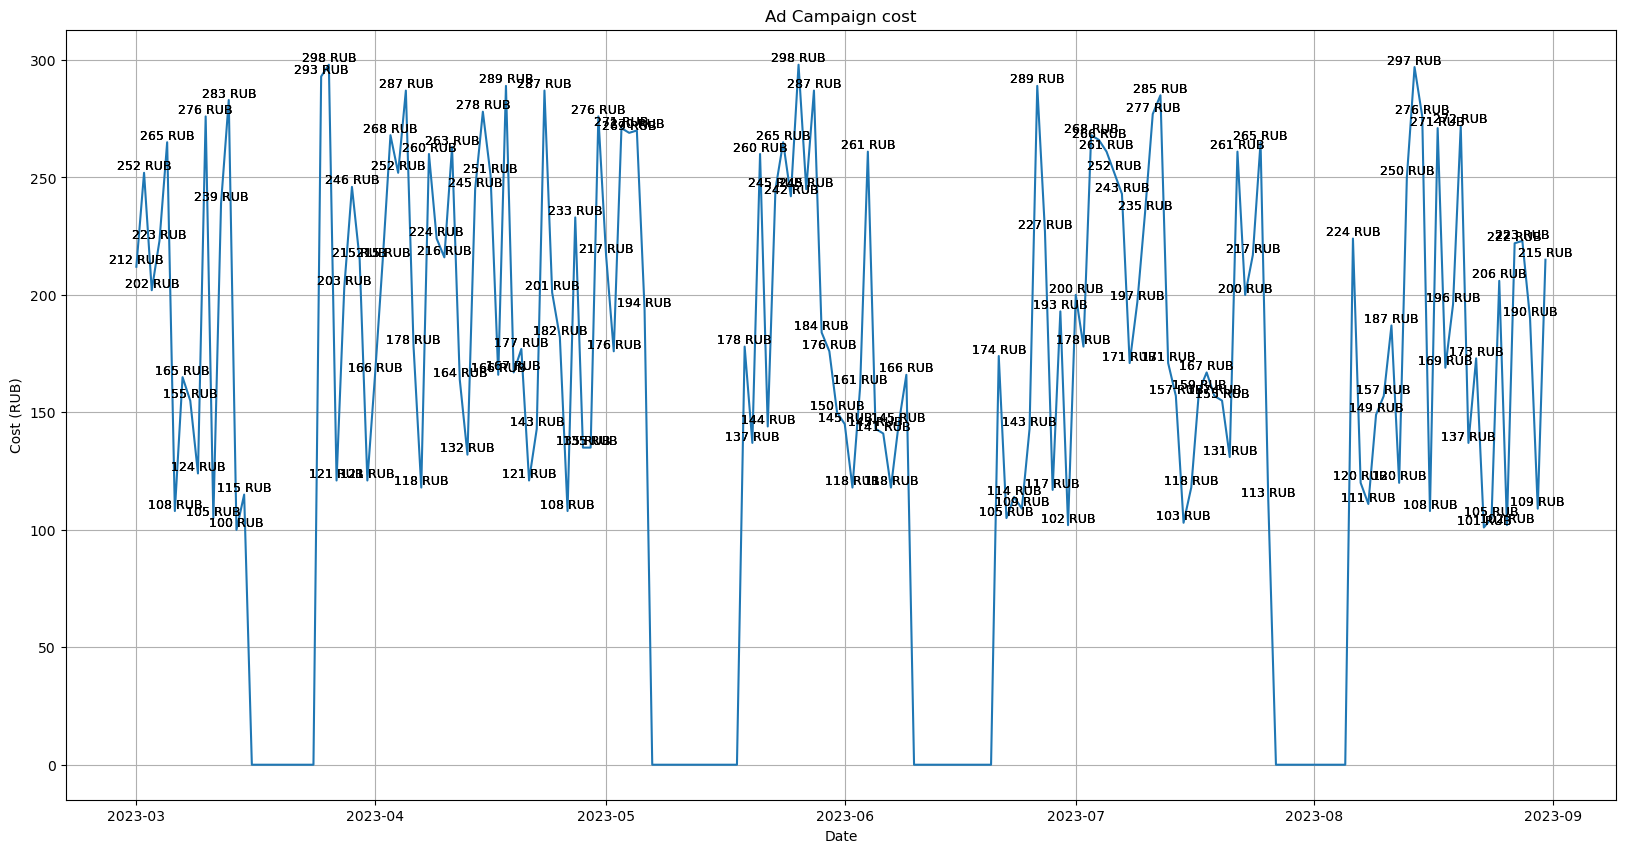

In [20]:
fig, ax = plt.subplots(figsize=(20, 10))

ax.plot(ads['date_group'], ads['cost'])
ax.set_xlabel('Date')
ax.set_ylabel('Cost (RUB)')
ax.set_title('Ad Campaign cost')
ax.grid(True)
for x, y in zip(ads['date_group'], ads['cost'],):
    if y != 0:
        ax.text(x, y, f'{y:.0f} RUB', ha='center', va='bottom', fontsize=9)
plt.savefig('charts/Ad Campaign cost', format='png')
plt.show()

C:\Users\dmitr\AppData\Local\Temp\ipykernel_34620\865278929.py:46: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


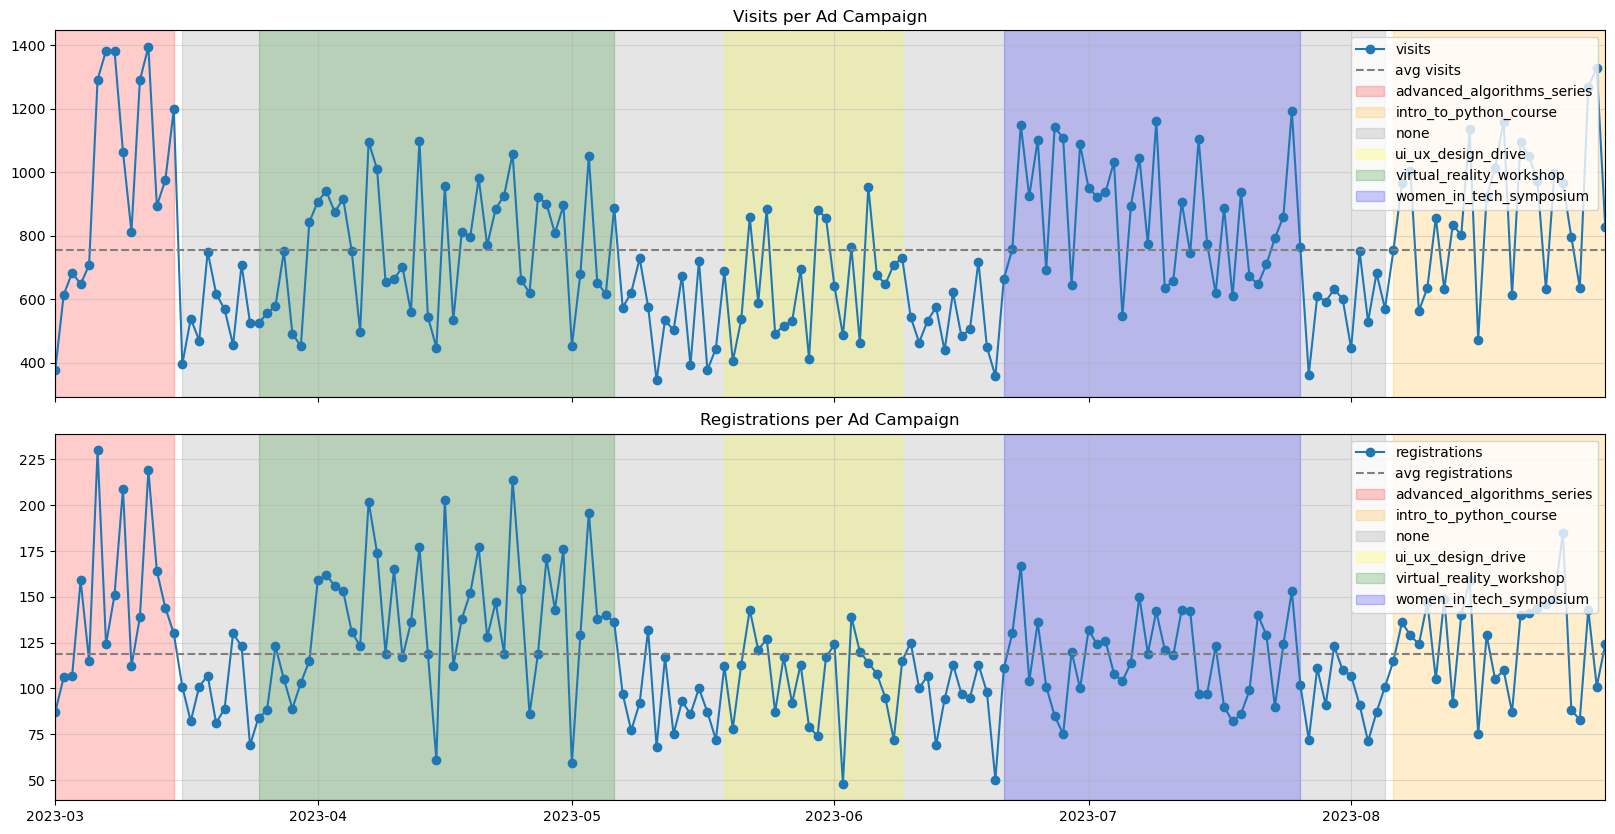

In [21]:
visits_c = ads.groupby(['date_group', 'utm_campaign']).agg({'visits':'sum'}).reset_index()
registrations_c = ads.groupby(['date_group', 'utm_campaign']).agg({'registrations':'sum'}).reset_index()

ads_periods = visits_c[['utm_campaign', 'date_group']].groupby('utm_campaign').apply(lambda x : x.loc[(x['date_group'] == x['date_group'].min()) | (x['date_group'] == x['date_group'].max())]).reset_index(drop=True)
ads_start = ads_periods.groupby('utm_campaign')['date_group'].agg('min').reset_index()
ads_start.columns = ['utm_campaign', 'start'] 
ads_end = ads_periods.groupby('utm_campaign')['date_group'].agg('max').reset_index()
ads_end.columns = ['utm_campaign', 'end'] 
ads_from_start_to_end = ads_start.merge(ads_end)

ads_from_start_to_end['start'] = pd.to_datetime(ads_from_start_to_end['start'], format='%Y-%m-%d')
ads_from_start_to_end['end'] = pd.to_datetime(ads_from_start_to_end['end'], format='%Y-%m-%d')

ads_from_start_to_end = ads_from_start_to_end.replace(['2023-04-06'],'2023-04-05')
ads_from_start_to_end = ads_from_start_to_end.replace(['2023-04-08'],'2023-04-09')
ads_from_start_to_end = ads_from_start_to_end.replace(['2023-07-28'],'2023-07-29')

fig, ax = plt.subplots(2, sharex=True)
fig.set_size_inches(20, 10)
fig.subplots_adjust(hspace=0.1)

visits_c['mean_visits'] = visits_c['visits'].mean()
registrations_c['mean_registrations'] = registrations_c['registrations'].mean()

campaign_colors = dict(zip(ads_from_start_to_end['utm_campaign'].unique(), ['red', 'orange', 'grey', 'yellow', 'green', 'blue']))

ax[0].title.set_text('Visits per Ad Campaign')
ax[0].plot(visits_c['date_group'], visits_c['visits'], label='visits', marker='o')
ax[0].plot(visits_c['date_group'], visits_c['mean_visits'], label='avg visits', linestyle='dashed', color='grey')
for _, row in ads_from_start_to_end.iterrows():
    ax[0].axvspan(row['start'], row['end'], alpha=0.2, label=row['utm_campaign'], color=campaign_colors[row['utm_campaign']])
ax[0].legend(loc='upper right')
ax[0].grid(alpha=0.4)
ax[0].margins(x=0)

ax[1].title.set_text('Registrations per Ad Campaign')
ax[1].plot(registrations_c['date_group'], registrations_c['registrations'], label='registrations', marker='o')
ax[1].plot(registrations_c['date_group'], registrations_c['mean_registrations'], label='avg registrations', linestyle='dashed', color='grey')
for _, row in ads_from_start_to_end.iterrows():
    ax[1].axvspan(row['start'], row['end'], alpha=0.2, label=row['utm_campaign'], color=campaign_colors[row['utm_campaign']])
ax[1].legend(loc='upper right')
ax[1].grid(alpha=0.4)
ax[1].margins(x=0)

fig.savefig('charts/Combined_Plot.png', format='png')
fig.show()


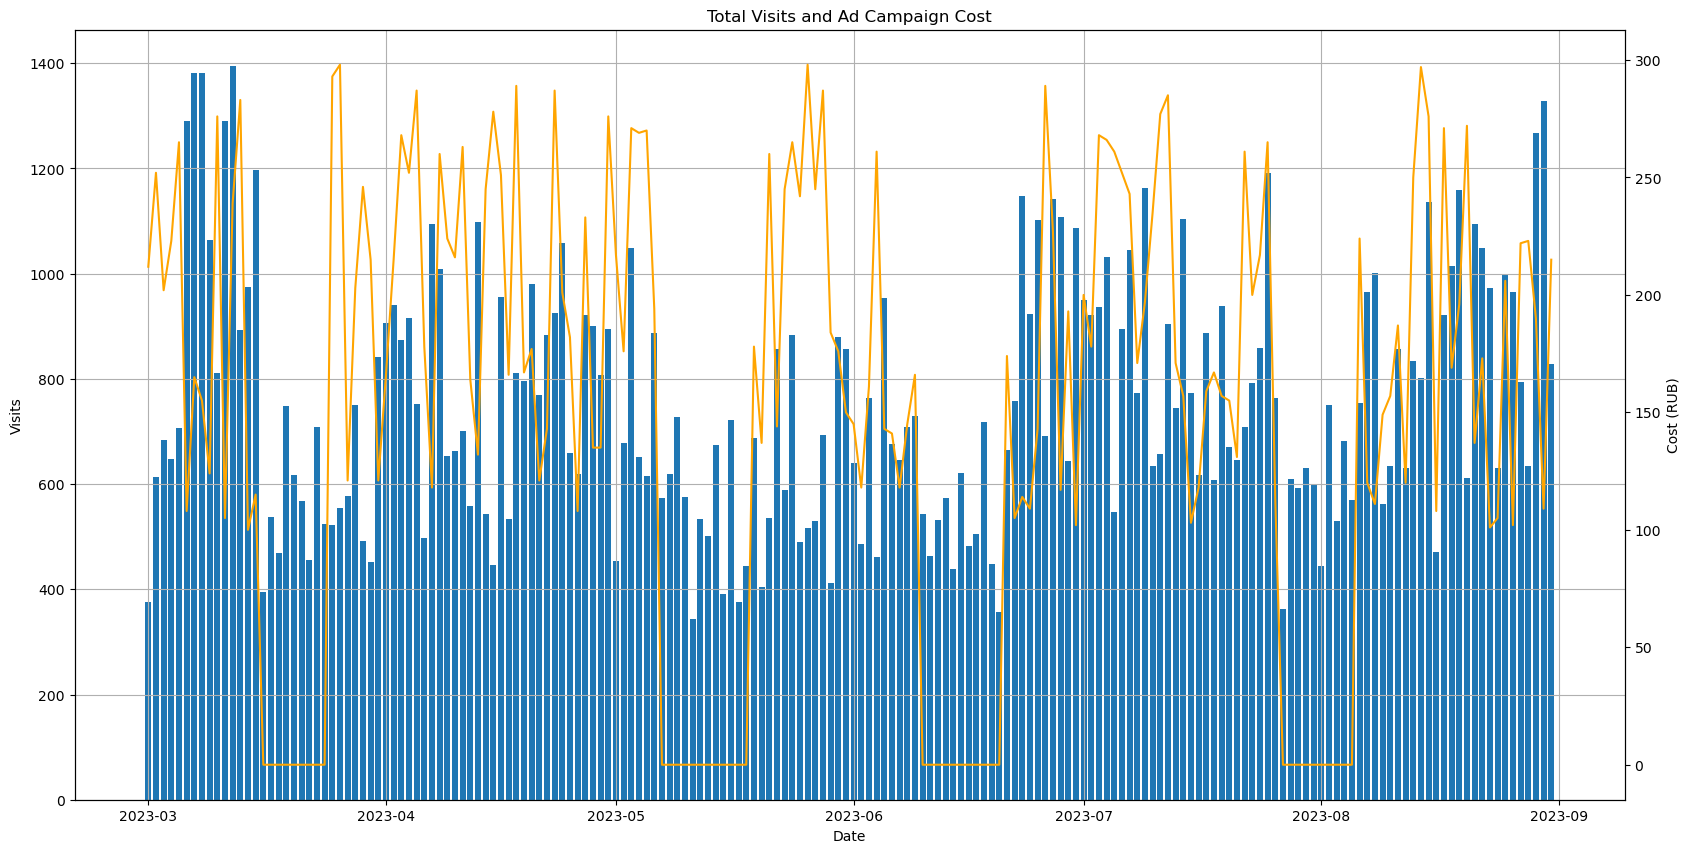

In [22]:
fig, ax1 = plt.subplots(figsize=(20, 10))

ax1.bar(total_visits['date_group'], total_visits['visits'], label='Total Visits')
ax1.set_xlabel('Date')
ax1.set_ylabel('Visits')
ax1.tick_params(axis='y')
ax1.set_title('Total Visits and Ad Campaign Cost')
ax1.grid(True)

ax2 = ax1.twinx()
ax2.plot(ads['date_group'], ads['cost'], color='orange', label='Ad Campaign Cost')
ax2.set_ylabel('Cost (RUB)')
ax2.tick_params(axis='y')

plt.savefig('charts/Total_Visits_and_Ad_Campaign_Cost.png', format='png')
plt.show()